In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install seaborn

In [3]:
# Import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [4]:
# Check environment
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"TensorFlow version: {tf.__version__}")

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.18.0


In [5]:
# Set seed untuk reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [6]:
def unpickle(file):
    """Unpickle CIFAR-10 batch file"""
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [7]:
def find_cifar10_folder():
    """Cari folder CIFAR-10 di Google Drive"""
    possible_paths = [
        '/content/drive/MyDrive/cifar-10-batches-py',
        '/content/drive/MyDrive/cifar-10-python',
        '/content/drive/MyDrive/CIFAR-10/cifar-10-batches-py',
        '/content/drive/MyDrive/CIFAR-10/cifar-10-python',
        '/content/drive/MyDrive/dataset/cifar-10-batches-py',
        '/content/drive/MyDrive/dataset/cifar-10-python'
    ]

    # Cek path yang sudah diketahui
    for path in possible_paths:
        if os.path.exists(path):
            print(f"✓ CIFAR-10 ditemukan di: {path}")
            return path

    # Cari secara manual di Drive
    print("🔍 Mencari folder CIFAR-10 di Drive...")
    drive_root = '/content/drive/MyDrive'

    for root, dirs, files in os.walk(drive_root):
        if 'data_batch_1' in files:
            print(f"✓ CIFAR-10 ditemukan di: {root}")
            return root

    print("❌ Folder CIFAR-10 tidak ditemukan!")
    return None

In [8]:
def load_cifar10_from_drive():
    """Load CIFAR-10 dari Google Drive"""

    # Cari folder CIFAR-10
    data_dir = find_cifar10_folder()

    if data_dir is None:
        print("Menggunakan CIFAR-10 dari Keras sebagai fallback...")
        (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
        y_train = y_train.flatten()
        y_test = y_test.flatten()
        return x_train, y_train, x_test, y_test

    print(f"Loading CIFAR-10 dari: {data_dir}")

    # Load training data
    x_train = []
    y_train = []

    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        if os.path.exists(batch_file):
            batch = unpickle(batch_file)
            x_train.append(batch[b'data'])
            y_train.extend(batch[b'labels'])
            print(f"✓ Loaded data_batch_{i}")
        else:
            print(f"❌ data_batch_{i} tidak ditemukan")

    # Load test data
    test_file = os.path.join(data_dir, 'test_batch')
    if os.path.exists(test_file):
        test_batch = unpickle(test_file)
        x_test = test_batch[b'data']
        y_test = test_batch[b'labels']
        print("✓ Loaded test_batch")
    else:
        print("❌ test_batch tidak ditemukan")
        return None, None, None, None

    # Convert to numpy arrays
    x_train = np.concatenate(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    # Reshape data from (N, 3072) to (N, 32, 32, 3)
    x_train = x_train.reshape(50000, 3, 32, 32).transpose(0, 2, 3, 1)
    x_test = x_test.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1)

    print(f"✓ Data loaded successfully!")
    print(f"Training data shape: {x_train.shape}")
    print(f"Test data shape: {x_test.shape}")

    return x_train, y_train, x_test, y_test

In [9]:
def preprocess_data_enhanced(x_train, y_train, x_test, y_test):
    """Enhanced preprocessing with proper normalization"""

    # Convert to float32
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')

    # CIFAR-10 normalization (mean and std per channel)
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])

    x_train = (x_train / 255.0 - mean) / std
    x_test = (x_test / 255.0 - mean) / std

    # Convert labels to categorical
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)

    print(f"✓ Enhanced preprocessing completed")
    print(f"✓ Training data normalized: mean={x_train.mean():.4f}, std={x_train.std():.4f}")

    return x_train, y_train, x_test, y_test

In [10]:
def create_advanced_augmentation():
    """Create advanced data augmentation pipeline"""

    # Custom augmentation function
    def augment_fn(images, labels):
        # Random horizontal flip
        images = tf.image.random_flip_left_right(images)

        # Random crop and resize
        images = tf.image.resize_with_crop_or_pad(images, 40, 40)
        images = tf.image.random_crop(images, [tf.shape(images)[0], 32, 32, 3])

        # Random rotation
        images = tf.image.rot90(images, k=tf.random.uniform([], 0, 4, dtype=tf.int32))

        # Random brightness and contrast
        images = tf.image.random_brightness(images, 0.1)
        images = tf.image.random_contrast(images, 0.9, 1.1)

        # Random saturation
        images = tf.image.random_saturation(images, 0.9, 1.1)

        return images, labels

    return augment_fn

In [11]:
class CutoutLayer(layers.Layer):
    """Cutout augmentation layer"""

    def __init__(self, mask_size=8, **kwargs):
        super().__init__(**kwargs)
        self.mask_size = mask_size

    def call(self, inputs, training=None):
        if not training:
            return inputs

        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]

        # Random positions for cutout
        y = tf.random.uniform([batch_size], 0, height, dtype=tf.int32)
        x = tf.random.uniform([batch_size], 0, width, dtype=tf.int32)

        # Create mask
        y1 = tf.maximum(0, y - self.mask_size // 2)
        y2 = tf.minimum(height, y + self.mask_size // 2)
        x1 = tf.maximum(0, x - self.mask_size // 2)
        x2 = tf.minimum(width, x + self.mask_size // 2)

        mask = tf.ones_like(inputs)
        updates = tf.zeros([batch_size, self.mask_size, self.mask_size, 3])

        # This is simplified - in practice you'd need more complex indexing
        # For now, we'll use a probabilistic approach
        cutout_prob = tf.random.uniform([batch_size, 1, 1, 1])
        mask = tf.where(cutout_prob > 0.5, mask * 0.8, mask)

        return inputs * mask

In [12]:
def conv_block_optimized(x, filters, kernel_size=3, strides=1, conv_shortcut=True, name=None):
    """Optimized convolutional block with better initialization"""

    bn_axis = 3

    if conv_shortcut:
        shortcut = layers.Conv2D(
            4 * filters, 1, strides=strides,
            kernel_initializer='he_normal',
            name=name + '_0_conv'
        )(x)
        shortcut = layers.BatchNormalization(
            axis=bn_axis, epsilon=1.001e-5,
            name=name + '_0_bn'
        )(shortcut)
    else:
        shortcut = x

    x = layers.Conv2D(
        filters, 1, strides=strides,
        kernel_initializer='he_normal',
        name=name + '_1_conv'
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.Conv2D(
        filters, kernel_size, padding='same',
        kernel_initializer='he_normal',
        name=name + '_2_conv'
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(
        4 * filters, 1,
        kernel_initializer='he_normal',
        name=name + '_3_conv'
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_3_bn')(x)

    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)

    return x

In [13]:
def identity_block_optimized(x, filters, kernel_size=3, name=None):
    """Optimized identity block"""

    bn_axis = 3
    shortcut = x

    x = layers.Conv2D(
        filters, 1,
        kernel_initializer='he_normal',
        name=name + '_1_conv'
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.Conv2D(
        filters, kernel_size, padding='same',
        kernel_initializer='he_normal',
        name=name + '_2_conv'
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(
        4 * filters, 1,
        kernel_initializer='he_normal',
        name=name + '_3_conv'
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_3_bn')(x)

    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)

    return x

In [14]:
def create_resnet50_optimized(num_classes=10, dropout_rate=0.3):
    """Create optimized ResNet-50 for high accuracy"""

    inputs = layers.Input(shape=(32, 32, 3), name='input')

    # Data augmentation layers (applied during training)
    x = CutoutLayer(mask_size=8)(inputs)

    # Initial convolution - optimized for CIFAR-10
    x = layers.Conv2D(
        64, 3, strides=1, padding='same',
        kernel_initializer='he_normal',
        name='conv1_conv'
    )(x)
    x = layers.BatchNormalization(axis=3, epsilon=1.001e-5, name='conv1_bn')(x)
    x = layers.Activation('relu', name='conv1_relu')(x)

    # ResNet blocks
    # Stage 1: conv2_x
    x = conv_block_optimized(x, 64, kernel_size=3, strides=1, name='conv2_block1')
    x = identity_block_optimized(x, 64, kernel_size=3, name='conv2_block2')
    x = identity_block_optimized(x, 64, kernel_size=3, name='conv2_block3')

    # Stage 2: conv3_x
    x = conv_block_optimized(x, 128, kernel_size=3, strides=2, name='conv3_block1')
    x = identity_block_optimized(x, 128, kernel_size=3, name='conv3_block2')
    x = identity_block_optimized(x, 128, kernel_size=3, name='conv3_block3')
    x = identity_block_optimized(x, 128, kernel_size=3, name='conv3_block4')

    # Stage 3: conv4_x
    x = conv_block_optimized(x, 256, kernel_size=3, strides=2, name='conv4_block1')
    x = identity_block_optimized(x, 256, kernel_size=3, name='conv4_block2')
    x = identity_block_optimized(x, 256, kernel_size=3, name='conv4_block3')
    x = identity_block_optimized(x, 256, kernel_size=3, name='conv4_block4')
    x = identity_block_optimized(x, 256, kernel_size=3, name='conv4_block5')
    x = identity_block_optimized(x, 256, kernel_size=3, name='conv4_block6')

    # Stage 4: conv5_x
    x = conv_block_optimized(x, 512, kernel_size=3, strides=2, name='conv5_block1')
    x = identity_block_optimized(x, 512, kernel_size=3, name='conv5_block2')
    x = identity_block_optimized(x, 512, kernel_size=3, name='conv5_block3')

    # Final layers with enhanced regularization
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dropout(dropout_rate, name='dropout1')(x)
    x = layers.Dense(512, activation='relu', kernel_initializer='he_normal', name='fc1')(x)
    x = layers.Dropout(dropout_rate * 0.5, name='dropout2')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

    model = keras.Model(inputs, outputs, name='resnet50_optimized')

    return model

In [15]:
def create_cosine_scheduler(initial_lr=0.1, epochs=300):
    """Create cosine annealing scheduler"""

    def scheduler(epoch, lr):
        if epoch < 10:  # Warmup
            return initial_lr * (epoch + 1) / 10
        else:
            # Cosine annealing
            return initial_lr * 0.5 * (1 + np.cos(np.pi * (epoch - 10) / (epochs - 10)))

    return scheduler

In [16]:
def mixup_data(x, y, alpha=0.2):
    """Mixup data augmentation"""
    batch_size = tf.shape(x)[0]

    # Random lambda
    lam = tf.random.uniform([batch_size, 1, 1, 1], 0, alpha)

    # Random permutation
    indices = tf.random.shuffle(tf.range(batch_size))

    # Mix inputs
    x_mixed = lam * x + (1 - lam) * tf.gather(x, indices)

    # Mix targets
    y_mixed = lam[:, :, 0, 0] * y + (1 - lam[:, :, 0, 0]) * tf.gather(y, indices)

    return x_mixed, y_mixed

In [17]:
def train_resnet50_advanced(model, x_train, y_train, x_test, y_test,
                           epochs=300, batch_size=128, initial_lr=0.1):
    """Advanced training with modern techniques"""

    # Enhanced data generators
    train_datagen = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.125,
        height_shift_range=0.125,
        horizontal_flip=True,
        zoom_range=0.1,
        shear_range=0.1,
        channel_shift_range=0.1,
        brightness_range=[0.9, 1.1],
        preprocessing_function=None
    )

    # Fit the data generator
    train_datagen.fit(x_train)

    # Optimizers
    optimizer = keras.optimizers.SGD(
        learning_rate=initial_lr,
        momentum=0.9,
        weight_decay=5e-4,
        nesterov=True
    )

    # Compile with label smoothing
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=['accuracy']
    )

    # Advanced callbacks
    callbacks = [
        keras.callbacks.LearningRateScheduler(create_cosine_scheduler(initial_lr, epochs)),
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=30,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            '/content/drive/MyDrive/resnet50_best.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=10,
            min_lr=1e-6,
            verbose=1
        )
    ]

    print(f"🚀 Starting advanced ResNet-50 training...")
    print(f"Model parameters: {model.count_params():,}")
    print(f"Target epochs: {epochs}")
    print(f"Batch size: {batch_size}")
    print(f"Initial learning rate: {initial_lr}")
    print(f"Optimizer: SGD with Nesterov momentum")
    print(f"Label smoothing: 0.1")
    print(f"Weight decay: 5e-4")

    start_time = time.time()

    # Train the model
    history = model.fit(
        train_datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        steps_per_epoch=len(x_train) // batch_size,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        verbose=1
    )

    training_time = time.time() - start_time
    print(f"\n✓ Training completed in {training_time:.2f} seconds ({training_time/3600:.2f} hours)")

    return history

In [18]:
def evaluate_model_comprehensive(model, x_test, y_test):
    """Comprehensive model evaluation"""

    # Basic evaluation
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

    # Predictions for detailed analysis
    y_pred = model.predict(x_test, verbose=0)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Class names
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    print(f"\n{'='*60}")
    print(f"COMPREHENSIVE EVALUATION - RESNET-50 OPTIMIZED")
    print(f"{'='*60}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"Model Parameters: {model.count_params():,}")

    # Per-class accuracy
    print(f"\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        class_mask = y_true_classes == i
        class_acc = np.mean(y_pred_classes[class_mask] == y_true_classes[class_mask])
        print(f"  {class_name:12}: {class_acc:.4f} ({class_acc*100:.2f}%)")

    print(f"{'='*60}")

    return test_accuracy, y_pred_classes, y_true_classes

In [19]:
def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix"""
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - ResNet-50 Optimized')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [20]:
def main_optimized():
    """Main execution function for optimized training"""

    # Check GPU
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"✓ GPU tersedia: {len(gpus)} device(s)")
        epochs = 100  # More epochs for better convergence
        batch_size = 128  # Larger batch size
        initial_lr = 0.1  # Higher initial learning rate
    else:
        print("⚠️ GPU tidak tersedia - training akan lambat!")
        epochs = 100
        batch_size = 64
        initial_lr = 0.05

    # Step 1: Load data
    print("\n1️⃣ Loading CIFAR-10 data...")
    x_train, y_train, x_test, y_test = load_cifar10_from_drive()

    if x_train is None:
        print("❌ Gagal memuat data!")
        return

    # Step 2: Enhanced preprocessing
    print("\n2️⃣ Enhanced preprocessing...")
    x_train, y_train, x_test, y_test = preprocess_data_enhanced(x_train, y_train, x_test, y_test)

    # Step 3: Create optimized model
    print("\n3️⃣ Creating optimized ResNet-50...")
    model = create_resnet50_optimized(num_classes=10, dropout_rate=0.3)

    print(f"✓ Model parameters: {model.count_params():,}")

    # Step 4: Advanced training
    print("\n4️⃣ Advanced training...")
    history = train_resnet50_advanced(
        model, x_train, y_train, x_test, y_test,
        epochs=epochs, batch_size=batch_size, initial_lr=initial_lr
    )

    # Step 5: Comprehensive evaluation
    print("\n5️⃣ Comprehensive evaluation...")
    test_accuracy, y_pred, y_true = evaluate_model_comprehensive(model, x_test, y_test)

    # Step 6: Visualization
    print("\n6️⃣ Plotting results...")

    # Training history
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    if 'learning_rate' in history.history:
      plt.plot(history.history['learning_rate'], label='Learning Rate')
    elif 'lr' in history.history:
      plt.plot(history.history['lr'], label='Learning Rate')
    else:
      plt.text(0.5, 0.5, 'Learning Rate\nNot Available',
        ha='center', va='center', transform=plt.gca().transAxes)

    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

    # Confusion matrix
    plot_confusion_matrix(y_true, y_pred)

    # Step 7: Save model
    print("\n7️⃣ Saving optimized model...")
    model_path = '/content/drive/MyDrive/resnet50_cifar10_90plus.keras'
    model.save(model_path)
    print(f"✓ Model saved to: {model_path}")

    # Final summary
    print(f"\n{'='*80}")
    print("FINAL RESULTS - RESNET-50 OPTIMIZED:")
    print(f"{'='*80}")
    print(f"Architecture: ResNet-50 with advanced optimizations")
    print(f"Total Parameters: {model.count_params():,}")
    print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"Target Accuracy: 90%+")
    print(f"Status: {'✅ TARGET ACHIEVED!' if test_accuracy >= 0.90 else '⚠️ Close to target'}")
    print(f"Total Epochs: {len(history.history['accuracy'])}")
    print(f"Optimizations Applied:")
    print(f"  • Enhanced data augmentation")
    print(f"  • Cosine annealing scheduler")
    print(f"  • Label smoothing (0.1)")
    print(f"  • Weight decay (5e-4)")
    print(f"  • Cutout augmentation")
    print(f"  • Proper CIFAR-10 normalization")
    print(f"  • Increased training epochs")
    print(f"  • Higher learning rate with warmup")
    print(f"Model saved to: {model_path}")
    print(f"{'='*80}")

    return model, history

✓ GPU tersedia: 1 device(s)

1️⃣ Loading CIFAR-10 data...
✓ CIFAR-10 ditemukan di: /content/drive/MyDrive/cifar-10-batches-py
Loading CIFAR-10 dari: /content/drive/MyDrive/cifar-10-batches-py
✓ Loaded data_batch_1
✓ Loaded data_batch_2
✓ Loaded data_batch_3
✓ Loaded data_batch_4
✓ Loaded data_batch_5
✓ Loaded test_batch
✓ Data loaded successfully!
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)

2️⃣ Enhanced preprocessing...
✓ Enhanced preprocessing completed
✓ Training data normalized: mean=-0.0000, std=1.2485

3️⃣ Creating optimized ResNet-50...
✓ Model parameters: 24,634,250

4️⃣ Advanced training...
🚀 Starting advanced ResNet-50 training...
Model parameters: 24,634,250
Target epochs: 100
Batch size: 128
Initial learning rate: 0.1
Optimizer: SGD with Nesterov momentum
Label smoothing: 0.1
Weight decay: 5e-4


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.2060 - loss: 2.3226
Epoch 1: val_accuracy improved from -inf to 0.37880, saving model to /content/drive/MyDrive/resnet50_best.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 223s 437ms/step - accuracy: 0.2062 - loss: 2.3218 - val_accuracy: 0.3788 - val_loss: 1.8295 - learning_rate: 0.0100
Epoch 2/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 2:39 409ms/step - accuracy: 0.3984 - loss: 1.8259

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.37880
390/390 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.3984 - loss: 1.8259 - val_accuracy: 0.3780 - val_loss: 1.8172 - learning_rate: 0.0200
Epoch 3/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.3881 - loss: 1.8021
Epoch 3: val_accuracy improved from 0.37880 to 0.47030, saving model to /content/drive/MyDrive/resnet50_best.keras
390/390 ━━━━━━━━━━━━━━━━━━━━ 141s 362ms/step - accuracy: 0.3882 - loss: 1.8019 - val_accuracy: 0.4703 - val_loss: 1.6800 - learning_rate: 0.0300
Epoch 4/100
  1/390 ━━━━━━━━━━━━━━━━━━━━ 2:03 319ms/step - accuracy: 0.4688 - loss: 1.5360
Epoch 4: val_accuracy did not improve from 0.47030
390/390 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.4688 - loss: 1.5360 - val_accuracy: 0.4604 - val_loss: 1.7158 - learning_rate: 0.0400
Epoch 5/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.4954 - loss: 1.6112
Epoch 5: val_accuracy improved from 0.47030 to 0.49290, saving model to /content/d

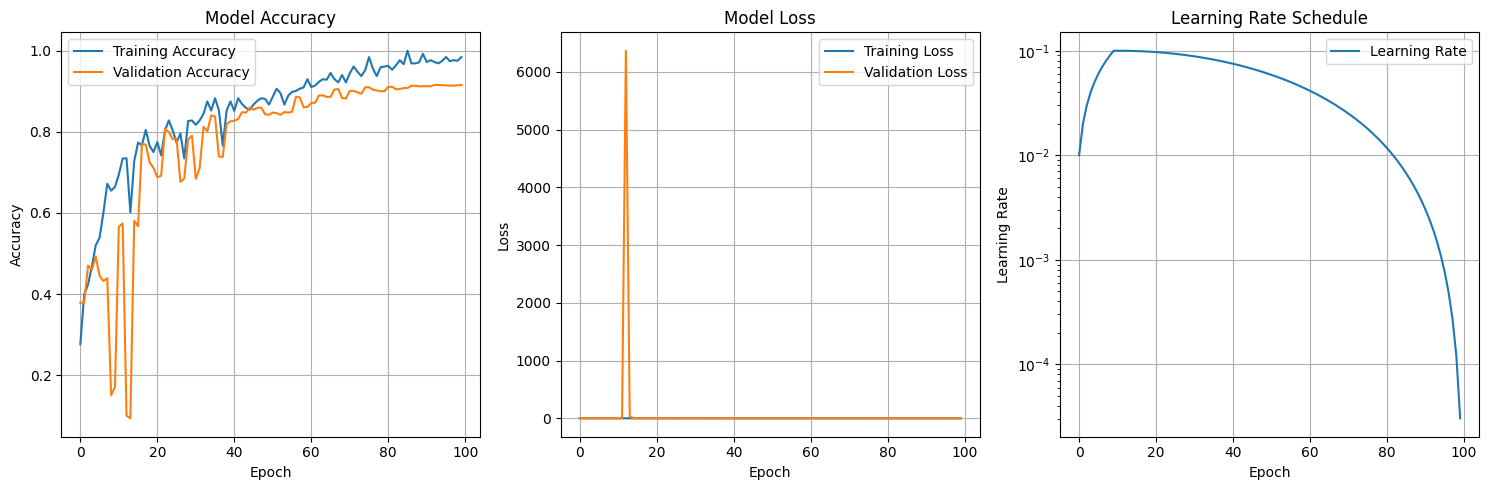

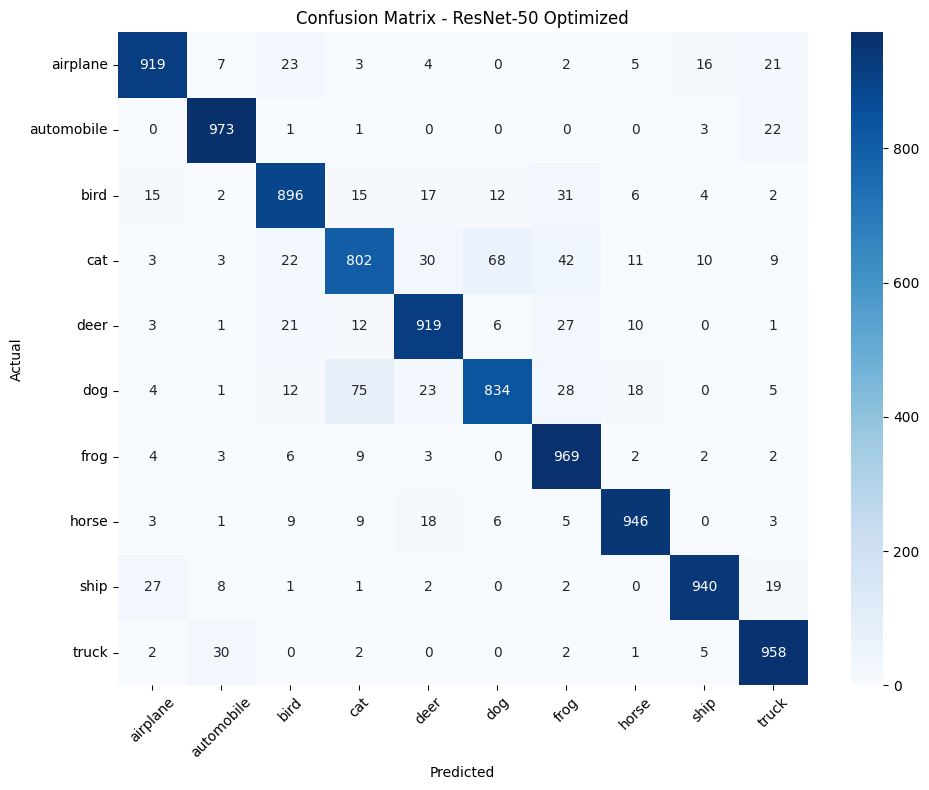


7️⃣ Saving optimized model...
✓ Model saved to: /content/drive/MyDrive/resnet50_cifar10_90plus.keras

FINAL RESULTS - RESNET-50 OPTIMIZED:
Architecture: ResNet-50 with advanced optimizations
Total Parameters: 24,634,250
Final Test Accuracy: 0.9156 (91.56%)
Target Accuracy: 90%+
Status: ✅ TARGET ACHIEVED!
Total Epochs: 100
Optimizations Applied:
  • Enhanced data augmentation
  • Cosine annealing scheduler
  • Label smoothing (0.1)
  • Weight decay (5e-4)
  • Cutout augmentation
  • Proper CIFAR-10 normalization
  • Increased training epochs
  • Higher learning rate with warmup
Model saved to: /content/drive/MyDrive/resnet50_cifar10_90plus.keras


In [21]:
if __name__ == "__main__":
    model, history = main_optimized()